In [1]:
import numpy as np
import pandas as pd

import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation

import matplotlib.pyplot as plt

import time
from datetime import datetime

import tba3102

In [2]:
tba3102.set_default_pandas_options(max_columns=11)

np.random.seed(int(round(time.time())))

In [3]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        
        if word in vocabulary:
            
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        
        feature_vector = np.divide(feature_vector, nwords)
    
    return feature_vector



def averaged_word_vectorizer(corpus, model, num_features):

    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) 
        for tokenized_sentence in corpus]
    
    return np.array(features)

In [4]:
df = pd.read_csv('../data/very_cleaned.csv', index_col=0)
# random_state = np.random.randint(2**31-1)
random_state = 945649140
print('random_state: {}'.format(random_state))

random_state: 945649140


In [5]:
df = df.sample(frac=0.50, replace=False, random_state=random_state)
df.reset_index(inplace=True)

print('Text processing started at {}'.format(datetime.now()))

Text processing started at 2025-02-20 19:20:34.428571


In [6]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in df['reviews.text_very_cleaned']]

In [7]:
# Set values for various parameters
feature_size = 100 # Word vector dimensionality
window_context = 10 # Context window size
min_word_count = 250 # Minimum word count
sample = 1e-3 # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, window=window_context, min_count=min_word_count, sample=sample, epochs=100)

c:\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


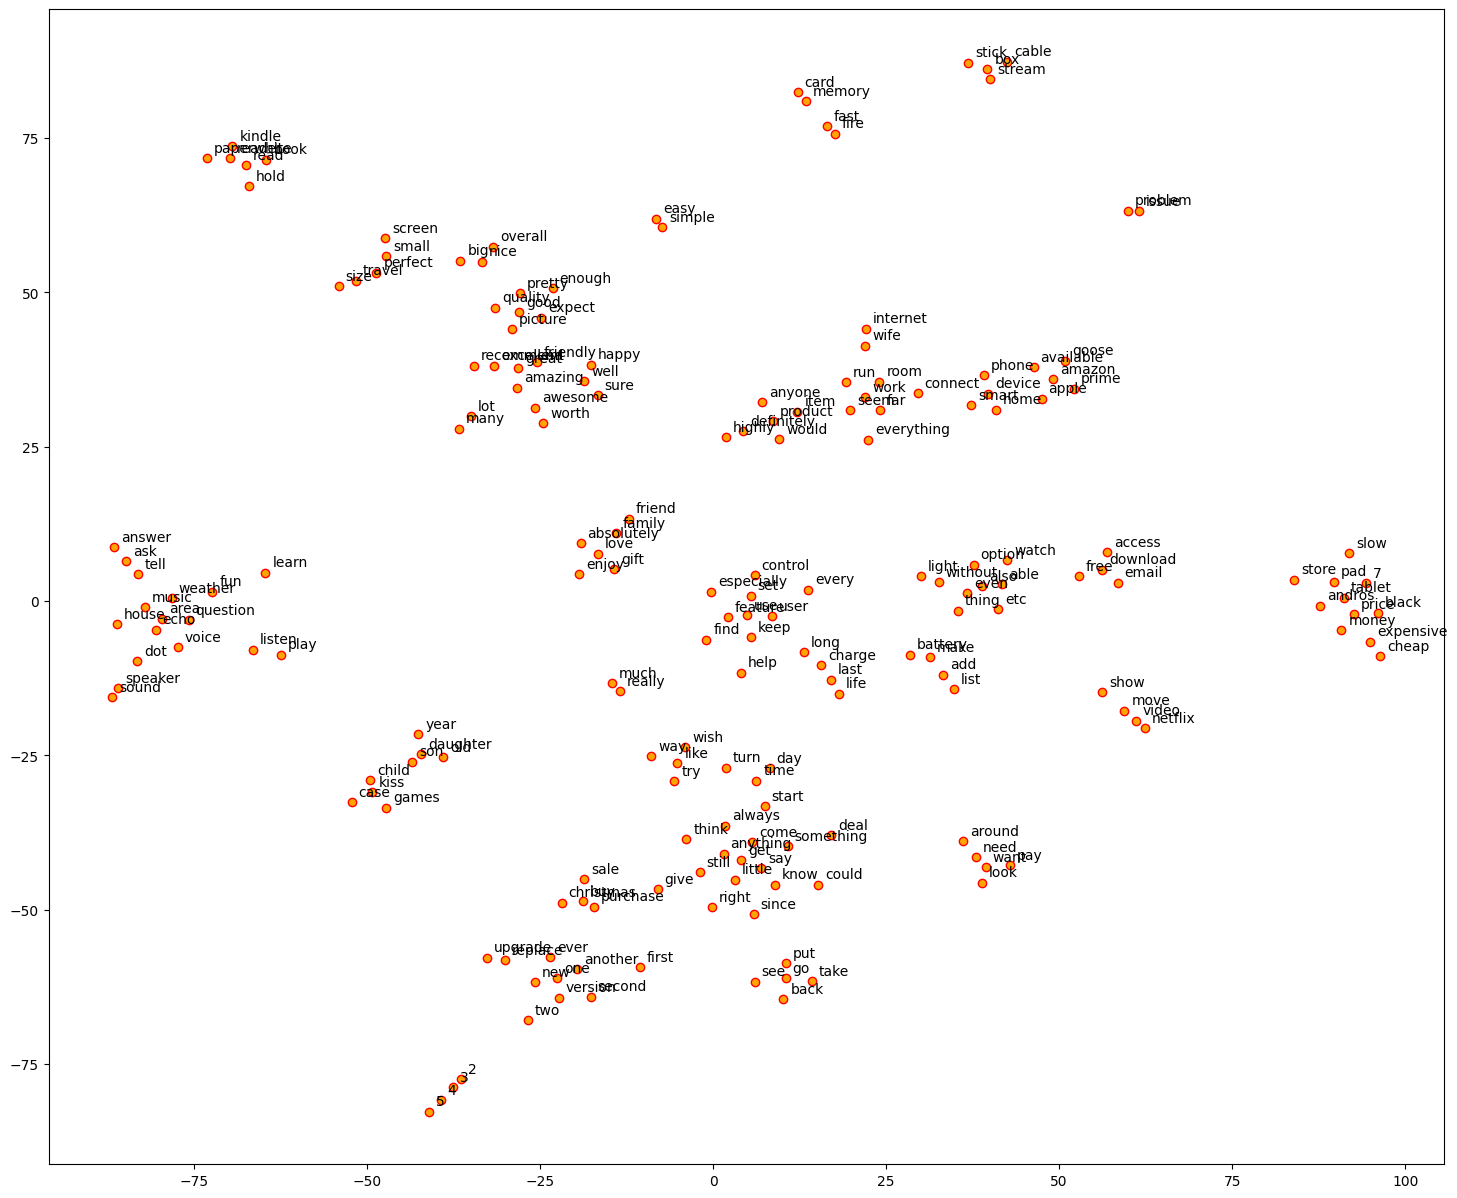

In [8]:
words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [9]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)

In [10]:
ap = AffinityPropagation(max_iter=500, damping=0.7, random_state=random_state)
ap.fit(w2v_feature_array)
cluster_centers_indices = ap.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_cluster_word2vec = pd.concat([df, cluster_labels], axis=1)
df_cluster_word2vec.to_csv('../data/cluster_word2vec.csv')

print('Estimated number of cluster is {}'.format(n_clusters_))

Estimated number of cluster is 663


In [11]:
print('Text processing ended at {}'.format(datetime.now()))

Text processing ended at 2025-02-20 19:33:05.108206
